# Mimicking ImageJ's watershed algorithm
In [ImageJ]() there is an algorithm called "Watershed" which allows splitting segmented dense objects within a binary image. This notebook demonstrates how to achieve a similar operation in Python. 

The "Watershed" in ImageJ was applied to a binary image using this macro:
```
open("../BioImageAnalysisNotebooks/data/blobs_otsu.tif");
run("Watershed");
```


In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import numpy as np

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import gaussian, sobel
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.morphology import binary_opening

Starting point for the demonstration is a binary image.

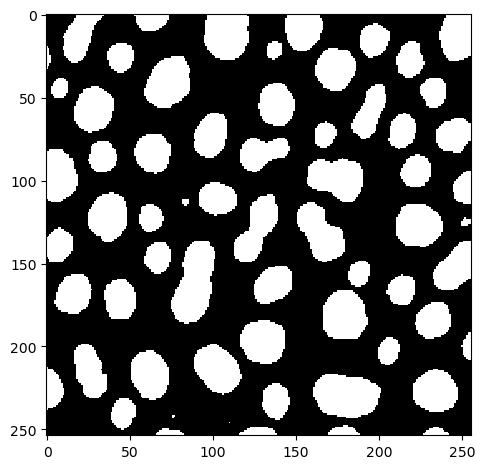

In [2]:
binary_image = imread("../../data/blobs_otsu.tif")
imshow(binary_image)

After applying the macro shown above, the result image in ImageJ looksl ike this:

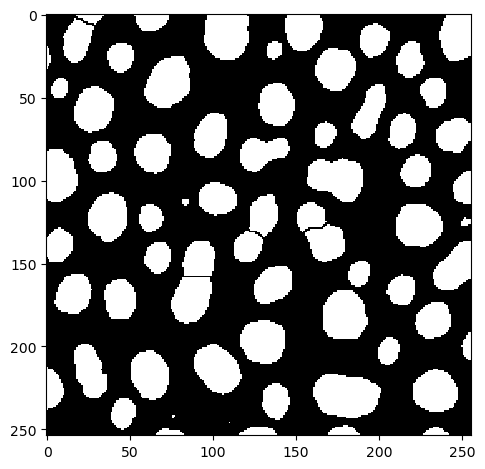

In [3]:
binary_watershed_imagej = imread("../../data/blobs_otsu_watershed.tif")
imshow(binary_watershed_imagej)

The Napari plugin [napari-segment-blobs-and-things-with-membranes](https://www.napari-hub.org/plugins/napari-segment-blobs-and-things-with-membranes#split-touching-objects-formerly-known-as-binary-watershed) offers a function for mimicking the functionality from ImageJ.

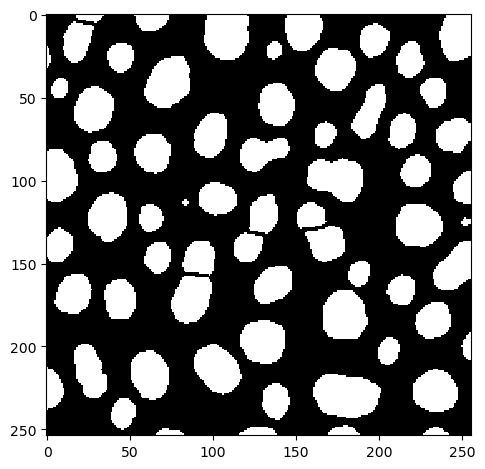

In [4]:
binary_watershed_nsbatwm = nsbatwm.split_touching_objects(binary_image)
imshow(binary_watershed_nsbatwm)

## Comparing results
When comparing results, it is obvious that the results are not 100% identical.

Text(0.5, 1.0, 'nsbatwm')

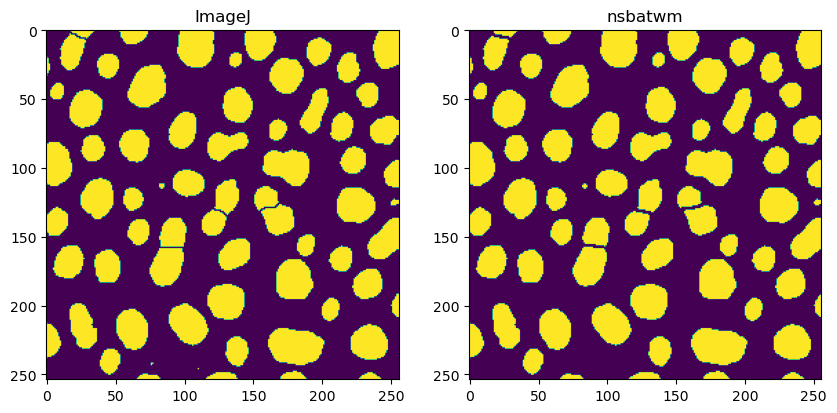

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(binary_watershed_imagej)
axs[0].set_title("ImageJ")
axs[1].imshow(binary_watershed_nsbatwm)
axs[1].set_title("nsbatwm")

## Fine-tuning results
Modifying the result is possible by tuning the `sigma` parameter.

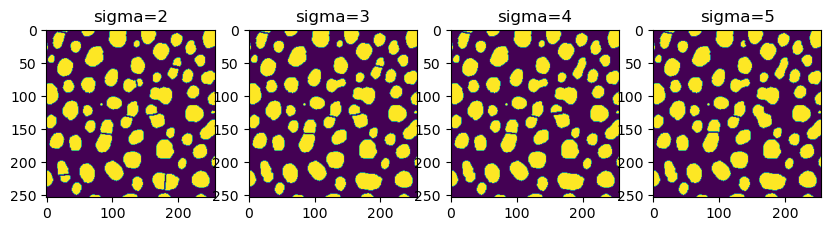

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(10,10))

for i, sigma in enumerate(np.arange(2, 6, 1)):
    result = nsbatwm.split_touching_objects(binary_image, sigma=sigma)
    axs[i].imshow(result)
    axs[i].set_title("sigma="+str(sigma))

## How does it work?
Under the hood, ImageJ's watershed algorithm uses a distance image and spot-detection. The following code attempts to replicate the result. 

Again, we start from the binary image.

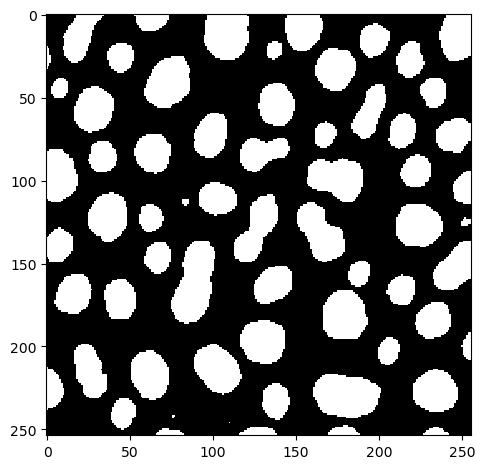

In [7]:
imshow(binary_image)

The first step is to produce a distance image.

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


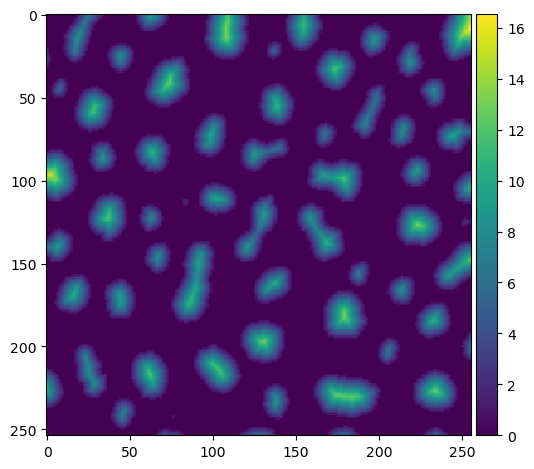

In [8]:
distance = ndi.distance_transform_edt(binary_image)
imshow(distance)

To avoid very small split objects, we blur the distance image using the `sigma` parameter.

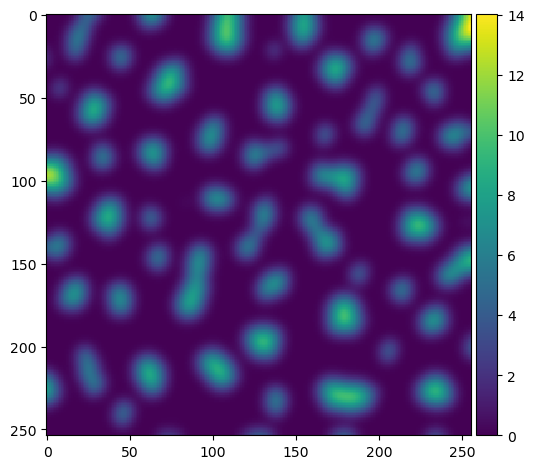

In [9]:
sigma = 3.5

blurred_distance = gaussian(distance, sigma=sigma)
imshow(blurred_distance)

Within this blurred image, we search for local maxima and receive them as list of coordinates.

In [10]:
fp = np.ones((3,) * binary_image.ndim)
coords = peak_local_max(blurred_distance, footprint=fp, labels=binary_image)

# show the first 5 only
coords[:5]

array([[  8, 254],
       [ 97,   1],
       [ 10, 108],
       [230, 180],
       [182, 179]], dtype=int64)

We next write these maxima into a new image and label them.

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


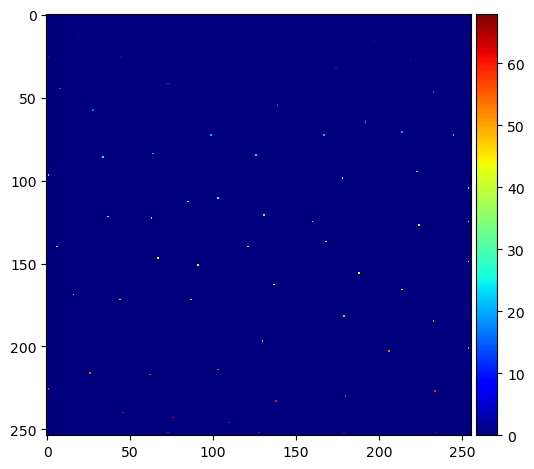

In [11]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = label(mask)
imshow(markers, cmap='jet')

Next, we apply [scikit-image's Watershed algorithm](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) ([example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html)). It takes a distance image and a label image as input. Optional input is the `binary_image` to limit spreading the labels too far.

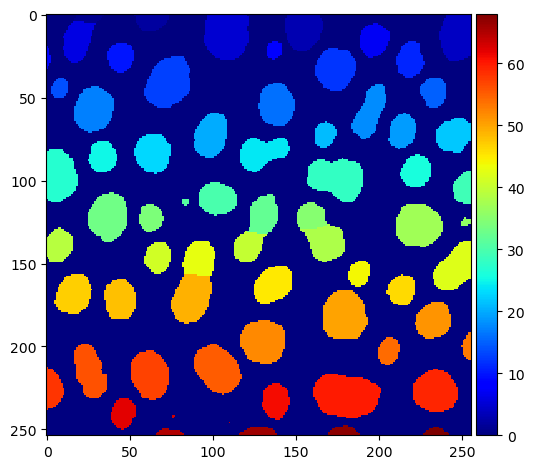

In [12]:
labels = watershed(-blurred_distance, markers, mask=binary_image)
imshow(labels, cmap='jet')

To create a binary image again as ImageJ does, we now identify the edges between the labels.

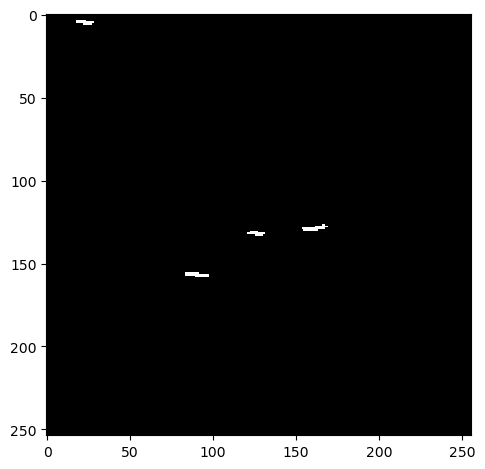

In [13]:
# identify label-cutting edges
edges_labels = sobel(labels)
edges_binary = sobel(binary_image)

edges = np.logical_xor(edges_labels != 0, edges_binary != 0)
imshow(edges)

Next we subtract those edges from the original `binary_image`.

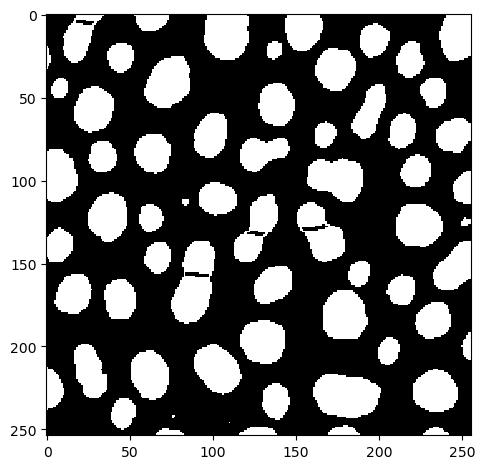

In [14]:
almost = np.logical_not(edges) * binary_image
imshow(almost)

As this result is not perfect yet, we apply a binary opening.

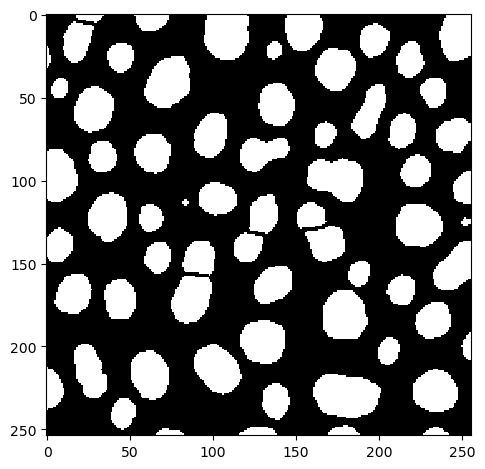

In [15]:
result = binary_opening(almost)
imshow(result)